<a href="https://colab.research.google.com/github/Deolinda1506/HumanActivityRecognition_HMM_G2/blob/main/Notebook/Hidden_markov_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Formative 2: Hidden Markov Models


# Project Overview

This project involves collecting motion sensor data, merging it, extracting meaningful features, and preparing it for modeling human activity states using a Hidden Markov Model (HMM). The target activities are standing, walking, jumping, and still.

## Data Collection

**Sensors Recorded:**
- Accelerometer: x, y, z axes
- Gyroscope: x, y, z axes

**Activities Performed:**

**Activity Details:**

- **Standing** (5–10 s): Keep the phone steady at waist level  
- **Walking** (5–10 s): Maintain a consistent pace  
- **Jumping** (5–10 s): Perform 3–5 continuous jumps  
- **Still** (5–10 s): Place the phone on a flat surface  

All recordings were taken at a **sampling rate of 50 Hz**, and the data was saved as `.csv` files with timestamps.

## Data Merging

Since accelerometer and gyroscope readings were recorded separately, we **merged them per activity** to form a single CSV per activity (e.g., `walking_merged.csv`).  
This ensures **time-aligned data from both sensors** for feature extraction and modeling.

## Feature Extraction

From the merged sensor readings, we extracted **time-domain and frequency-domain features** to capture movement patterns in each time window.  

**Time-domain features:**
- Mean, standard deviation, variance, mean absolute deviation (MAD) for each axis (`ax`, `ay`, `az`, `gx`, `gy`, `gz`)  
- Signal Magnitude Area (SMA) for accelerometer and gyroscope  
- Resultant acceleration: mean, std, variance, SMA  

**Frequency-domain features:**
- Dominant frequency (FFT)  
- Spectral energy  
- Top-3 FFT magnitudes and corresponding frequencies for each axis and resultant acceleration  

These features were saved into a file called `features.csv`, which contains all four activities combined with their corresponding labels.  
They form the **observation sequences** for the HMM model.

## Data Visualization

To inspect the quality of the collected data, we visualized the raw accelerometer and gyroscope axes as well as key features such as `acc_res_mean` and `acc_sma` for all activities.  
These visualizations help verify **signal integrity**, **activity distinctions**, and **consistency across recordings** before building the HMM.


In [1]:
%pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 3.7 MB/s eta 0:00:00


In [2]:
# libraries for Formative 2 HMM notebook


import os
import numpy as np
import pandas as pd
from scipy.fft import rfft, rfftfreq
from scipy.signal import welch
import matplotlib.pyplot as plt
import seaborn as sns
from hmmlearn import hmm
from itertools import product

sns.set(style="whitegrid")

In [3]:
# List of file paths
file_paths = [
    "/content/jumping_merged.csv",
    "/content/standing_merged.csv",
    "/content/still_merged.csv",
    "/content/walking_merged.csv"
]

# Read each CSV file and store them in a list
dataframes = [pd.read_csv(file_path) for file_path in file_paths]

# Concatenate the dataframes into a single dataframe
df = pd.concat(dataframes, ignore_index=True)

# Display basic info of the combined dataframe
print(df.head())
print(df.describe())
#sample_path = "data/merged/walking_merged.csv"


                  time        ax        ay        az        gx        gy  \
0  1761481512696706600 -0.810419  1.976186  1.937965 -0.189653 -0.380339   
1  1761481512716648700 -0.515804  2.001924  1.389326 -0.372137 -0.095206   
2  1761481512736591600  0.835055  1.125611  0.154222 -0.261454  0.211661   
3  1761481512756533500  1.596329 -0.006234 -0.757268 -0.027032  0.321824   
4  1761481512776476700  0.686389 -0.877214 -0.791083  0.129503  0.130611   

         gz activity_type  
0  0.007915       jumping  
1 -0.126276       jumping  
2  0.003749       jumping  
3  0.234760       jumping  
4  0.272821       jumping  
               time           ax           ay           az           gx  \
count  3.586000e+03  3586.000000  3586.000000  3586.000000  3586.000000   
mean   1.761472e+18     0.027189    -0.002583    -0.002553    -0.009415   
std    3.591984e+13     0.585521     1.823853     1.608650     0.301174   
min    1.761430e+18    -5.420056   -11.529718   -14.853647    -2.406366   


In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Folder where your merged data is stored
merged_dir = "/content"

# List of activities to visualize
activities = ["walking", "standing", "jumping", "still"]

# Create a directory to save plots if it doesn't exist
output_dir = "/content/activity_plots"
os.makedirs(output_dir, exist_ok=True)

# Create a single figure with subplots for each activity (2 rows for sensor type, 2 columns for activities)
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 8)) # Adjusted for 2 rows (accel/gyro) and 4 columns (activities)

# Loop through each activity to plot its data on respective subplots
for i, activity in enumerate(activities):
    file_path = os.path.join(merged_dir, f"{activity}_merged.csv")
    if not os.path.exists(file_path):
        print(f" File not found: {file_path}")
        continue

    # Load the file
    df = pd.read_csv(file_path)

    # Convert timestamp to seconds (assumes it's in microseconds or nanoseconds)
    # Normalize so time starts at zero for each activity plot
    df["time_sec"] = (df["time"] - df["time"].iloc[0]) / 1e6  # Convert to seconds

    # Plot Accelerometer data in the first row of subplots
    axes[0, i].plot(df["time_sec"], df["ax"], label="ax", alpha=0.8)
    axes[0, i].plot(df["time_sec"], df["ay"], label="ay", alpha=0.8)
    axes[0, i].plot(df["time_sec"], df["az"], label="az", alpha=0.8)
    axes[0, i].set_title(f"{activity.capitalize()} - Accelerometer")
    axes[0, i].set_xlabel("Time (seconds)")
    axes[0, i].set_ylabel("Acceleration (m/s²)")
    axes[0, i].legend()
    axes[0, i].grid(True)

    # Plot Gyroscope data in the second row of subplots
    axes[1, i].plot(df["time_sec"], df["gx"], label="gx", alpha=0.8)
    axes[1, i].plot(df["time_sec"], df["gy"], label="gy", alpha=0.8)
    axes[1, i].plot(df["time_sec"], df["gz"], label="gz", alpha=0.8)
    axes[1, i].set_title(f"{activity.capitalize()} - Gyroscope")
    axes[1, i].set_xlabel("Time (seconds)")
    axes[1, i].set_ylabel("Angular Velocity (°/s)") # Assuming units are degrees per second
    axes[1, i].legend()
    axes[1, i].grid(True)


# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()

# Save the single figure to a file
plt.savefig(os.path.join(output_dir, "all_activities_sensor_plots.png")) # Changed filename to reflect both sensors

# Close the figure to free up memory
plt.close(fig)

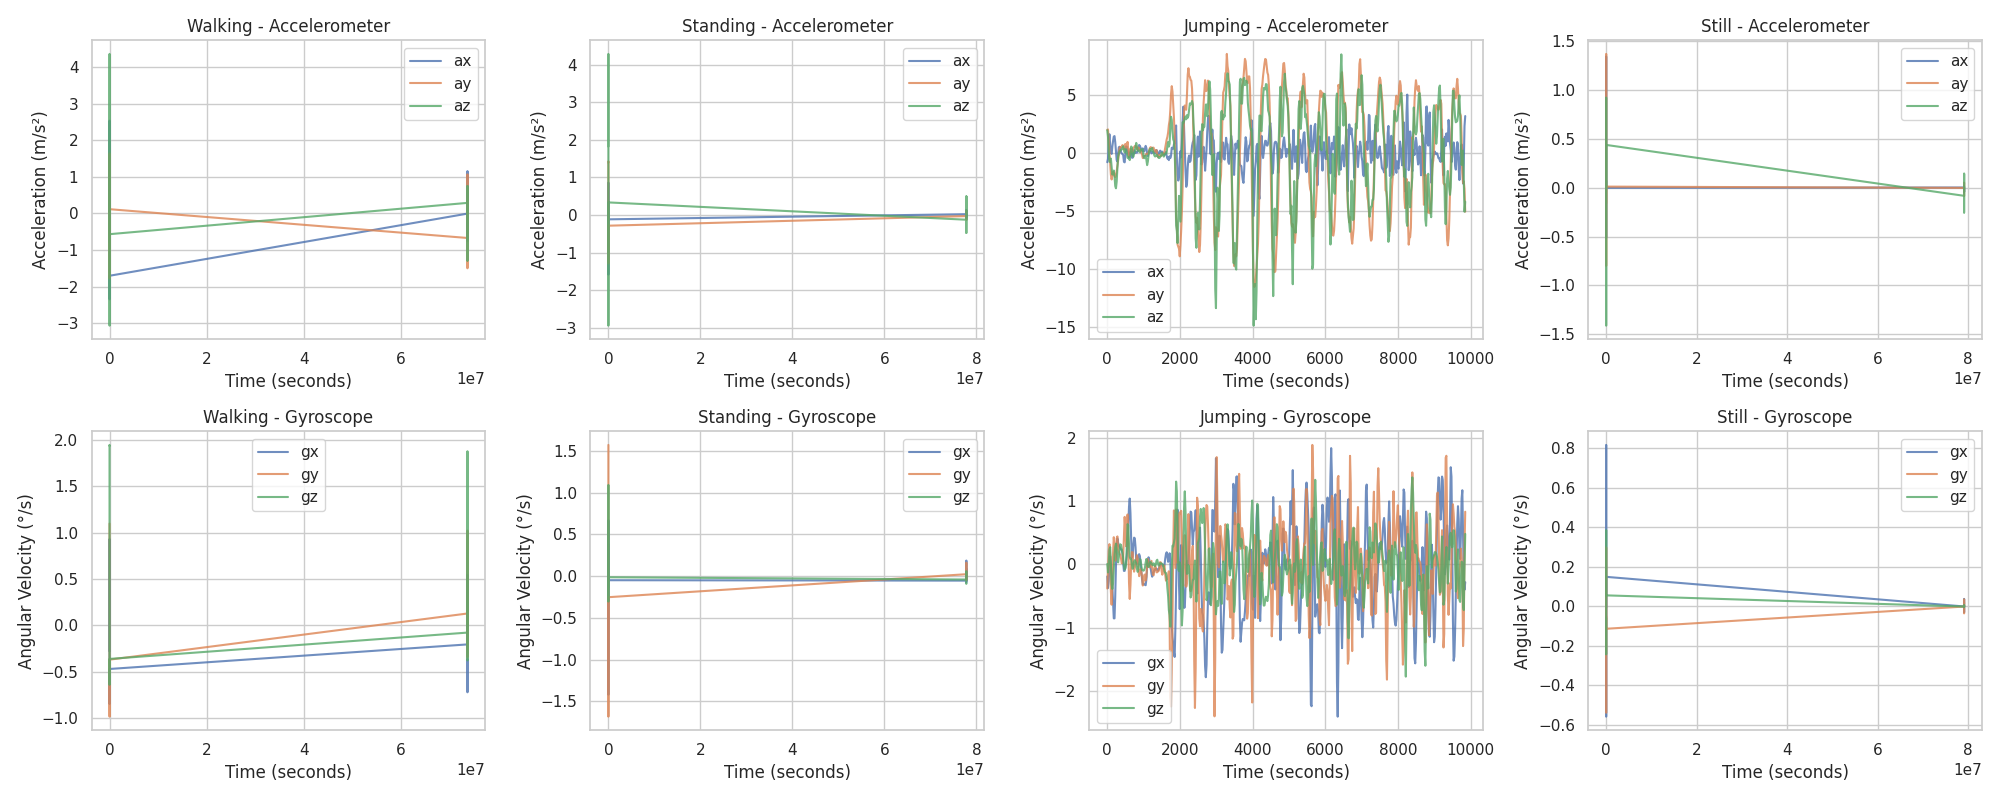

In [5]:
from IPython.display import Image

# Path to the saved combined image file
image_path = "/content/activity_plots/all_activities_sensor_plots.png"

# Display the image
Image(filename=image_path)

1. Load Extracted Features

In [6]:
import pandas as pd

# Load extracted features
df = pd.read_csv("/content/features.csv")
df.head()


,ax_mean,ax_std,ax_var,ax_mad,ax_dom_freq,ax_spec_energy,ax_fft_top1_mag,ax_fft_top1_freq,ax_fft_top2_mag,ax_fft_top2_freq,...,acc_res_spec_energy,acc_res_fft_top1_mag,acc_res_fft_top1_freq,acc_res_fft_top2_mag,acc_res_fft_top2_freq,acc_res_fft_top3_mag,acc_res_fft_top3_freq,gyro_sma,activity,start_time
0,0.323078,1.302039,0.935372,0.937548,-0.224536,-0.087071,0.818618,-0.224536,1.064643,-0.241966,...,1.935632,3.484073,-0.628093,2.039577,-0.681230,2.094093,-0.303988,0.969639,jumping,1.761482e+09
1,-0.670239,2.083211,2.211179,1.965954,-0.224536,3.146634,1.937029,-0.224536,1.802982,0.831271,...,2.441851,2.665754,0.041674,3.854700,-0.681230,4.231331,-0.940240,2.119637,jumping,1.761482e+09
2,-0.427866,2.424715,2.891934,2.420640,0.512990,3.892302,1.908934,0.512990,2.543986,0.343436,...,4.999581,2.767409,0.041674,3.466802,-0.253935,3.039964,-0.940240,2.083472,jumping,1.761482e+09
3,0.258573,2.309236,2.653364,2.276909,0.512990,1.496196,2.407531,0.512990,1.576024,0.441003,...,2.506955,2.663053,0.041674,2.799279,-0.742272,3.098719,-0.374682,2.047722,jumping,1.761482e+09
4,0.877804,2.062802,2.172866,2.165184,-0.224536,2.163168,1.457997,-0.224536,2.039272,0.831271,...,1.407435,2.273764,0.041674,0.936033,-0.253935,1.133664,0.120181,2.231906,jumping,1.761482e+09


Visualize raw accelerometer (ax, ay, az) and gyroscope (gx, gy, gz) signals for each activity and combined features like acc_sma, acc_res_mean from "features.csv".


Select relevant columns for plotting from the `features.csv` DataFrame.


Select the relevant columns for plotting from the loaded features DataFrame.



In [7]:
# Select relevant columns for plotting
feature_columns_to_plot = [
    "ax_mean", "ay_mean", "az_mean",
    "gx_mean", "gy_mean", "gz_mean",
    "acc_sma", "acc_res_mean",
    "activity"
]

df_features_plot = df[feature_columns_to_plot].copy()

display(df_features_plot.head())

,ax_mean,ay_mean,az_mean,gx_mean,gy_mean,gz_mean,acc_sma,acc_res_mean,activity
0,0.323078,-0.795208,-3.574432,0.204951,-0.680119,-0.162103,0.924327,0.907313,jumping
1,-0.670239,1.831010,1.545582,-1.899251,-0.573816,-0.343463,2.552801,2.546092,jumping
2,-0.427866,2.516388,3.138740,-0.822420,-0.310381,-0.346158,3.463949,3.476294,jumping
3,0.258573,-2.909846,-1.684047,1.337016,-0.114682,-0.286112,3.064878,3.111465,jumping
4,0.877804,1.909189,2.211583,-0.194416,0.475955,-0.182787,2.567525,2.582968,jumping


## Visualize raw sensor features

Create plots for the raw accelerometer and gyroscope features (ax, ay, az, gx, gy, gz) for each activity.


Create plots for the mean raw accelerometer and gyroscope features for each activity, ensuring consistent y-axis scales within each sensor type.



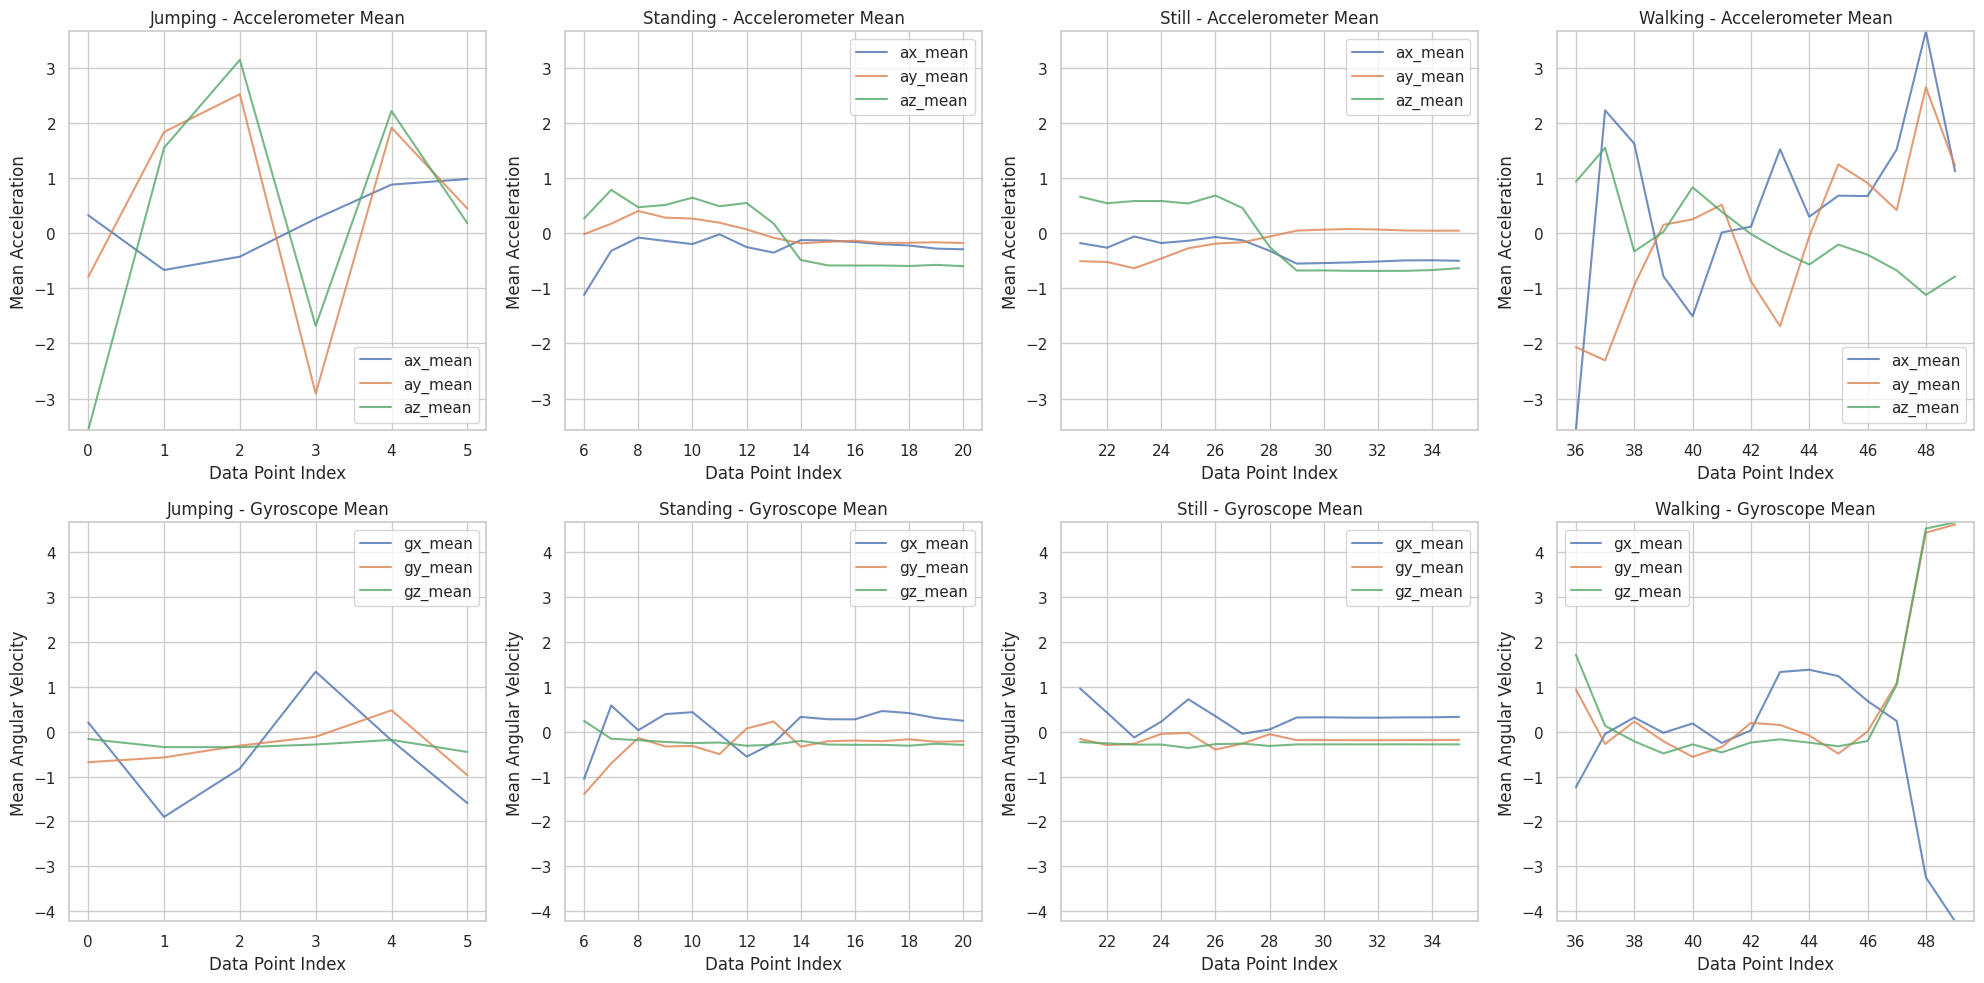

In [8]:
# Get unique activities
activities = df_features_plot['activity'].unique()

# Get sensor mean columns
accel_mean_cols = ["ax_mean", "ay_mean", "az_mean"]
gyro_mean_cols = ["gx_mean", "gy_mean", "gz_mean"]

# Determine consistent y-axis limits for accelerometer and gyroscope plots
accel_ymin = df_features_plot[accel_mean_cols].min().min()
accel_ymax = df_features_plot[accel_mean_cols].max().max()
gyro_ymin = df_features_plot[gyro_mean_cols].min().min()
gyro_ymax = df_features_plot[gyro_mean_cols].max().max()


# Create a figure with subplots (2 rows for sensor type, number of columns for activities)
# 2 rows * 4 activities = 8 subplots for raw mean features
fig, axes = plt.subplots(nrows=2, ncols=len(activities), figsize=(20, 10))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each activity to plot its data on respective subplots
for i, activity in enumerate(activities):
    # Filter data for the current activity
    df_activity = df_features_plot[df_features_plot['activity'] == activity]

    # Plot Accelerometer mean data in the first row of subplots
    ax_accel = axes[i] # First row: indices 0, 1, 2, 3
    for col in accel_mean_cols:
        ax_accel.plot(df_activity.index, df_activity[col], label=col, alpha=0.8)
    ax_accel.set_title(f"{activity.capitalize()} - Accelerometer Mean")
    ax_accel.set_xlabel("Data Point Index")
    ax_accel.set_ylabel("Mean Acceleration")
    ax_accel.set_ylim([accel_ymin, accel_ymax])
    ax_accel.legend()
    ax_accel.grid(True)

    # Plot Gyroscope mean data in the second row of subplots
    ax_gyro = axes[i + len(activities)] # Second row: indices 4, 5, 6, 7
    for col in gyro_mean_cols:
        ax_gyro.plot(df_activity.index, df_activity[col], label=col, alpha=0.8)
    ax_gyro.set_title(f"{activity.capitalize()} - Gyroscope Mean")
    ax_gyro.set_xlabel("Data Point Index")
    ax_gyro.set_ylabel("Mean Angular Velocity")
    ax_gyro.set_ylim([gyro_ymin, gyro_ymax])
    ax_gyro.legend()
    ax_gyro.grid(True)


# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()

## Visualize combined features

Create plots for combined features like `acc_sma` and `acc_res_mean` to highlight the differences between activities.


Create a figure with subplots to display the acc_sma and acc_res_mean features for each activity, then iterate through each unique activity, filter the dataframe for each activity, plot acc_sma and acc_res_mean on separate subplots, set consistent y-axis limits for each feature across all activities, add grids and legends, adjust layout, and display the plot.



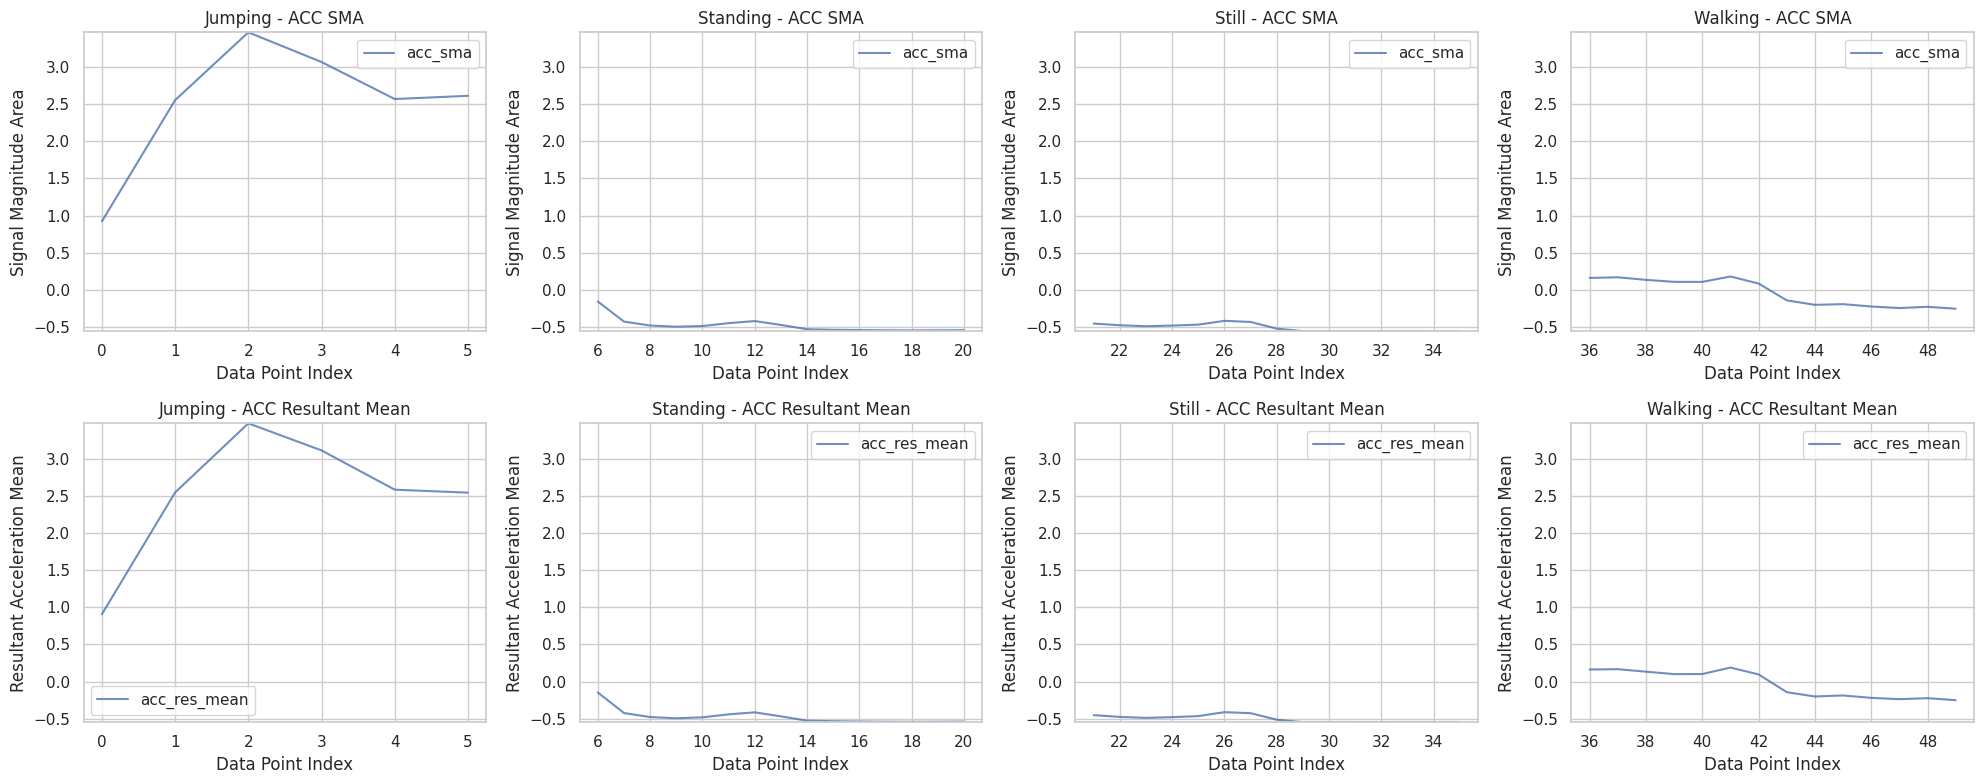

In [9]:
# Get unique activities from the dataframe
activities = df_features_plot['activity'].unique()

# Determine consistent y-axis limits for the combined features
acc_sma_ymin = df_features_plot["acc_sma"].min()
acc_sma_ymax = df_features_plot["acc_sma"].max()
acc_res_mean_ymin = df_features_plot["acc_res_mean"].min()
acc_res_mean_ymax = df_features_plot["acc_res_mean"].max()

# Create a figure with subplots (2 rows for features, number of columns for activities)
# 2 features * 4 activities = 8 subplots for combined features
fig, axes = plt.subplots(nrows=2, ncols=len(activities), figsize=(20, 8))

# Flatten axes array for easier indexing
axes = axes.flatten()

# Loop through each activity to plot its data on respective subplots
for i, activity in enumerate(activities):
    # Filter data for the current activity
    df_activity = df_features_plot[df_features_plot['activity'] == activity]

    # Plot acc_sma data in the first row of subplots
    ax_sma = axes[i] # First row: indices 0, 1, 2, 3
    ax_sma.plot(df_activity.index, df_activity["acc_sma"], label="acc_sma", alpha=0.8)
    ax_sma.set_title(f"{activity.capitalize()} - ACC SMA")
    ax_sma.set_xlabel("Data Point Index")
    ax_sma.set_ylabel("Signal Magnitude Area")
    ax_sma.set_ylim([acc_sma_ymin, acc_sma_ymax])
    ax_sma.legend()
    ax_sma.grid(True)

    # Plot acc_res_mean data in the second row of subplots
    ax_res_mean = axes[i + len(activities)] # Second row: indices 4, 5, 6, 7
    ax_res_mean.plot(df_activity.index, df_activity["acc_res_mean"], label="acc_res_mean", alpha=0.8)
    ax_res_mean.set_title(f"{activity.capitalize()} - ACC Resultant Mean")
    ax_res_mean.set_xlabel("Data Point Index")
    ax_res_mean.set_ylabel("Resultant Acceleration Mean")
    ax_res_mean.set_ylim([acc_res_mean_ymin, acc_res_mean_ymax])
    ax_res_mean.legend()
    ax_res_mean.grid(True)


# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()